# Vanilla Cross Entropy Training

In [1]:
!pip install -q timm seaborn wandb

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Get all the necessary imports
from fastai.vision.all import *
from fastai.callback.wandb import *
import wandb, datetime
plt.style.use("fivethirtyeight")
import seaborn as sns

In [4]:
# Start a new project in wandb
wandb.init(project = "oxford_flowers_classification")
wandb.run.name = "PolyLoss"

wandb: Currently logged in as: vinayak_nayak. Use `wandb login --relogin` to force relogin


# Define Dataloading portion

In [5]:
# Read the data file containing input output pairs and the datapoint class
df = pd.read_csv("../data/data.csv")

In [6]:
# Define getter for input ImageBlock
def get_x(row): 
    return f'../data/oxford-102-flowers/{row["ImgPath"]}'

# Define getter for output CategoryBlock
def get_y(row): 
    return row["ImgLabel"] 

# Define trian validation splitter
def splitter(df):
    train_idxs = df[df.SetType == "train"].index.tolist()
    valid_idxs = df[df.SetType == "valid"].index.tolist()
    return (train_idxs, valid_idxs)

# Define CPU based item transforms here
def get_item_tfms(size):
    return Resize(size, pad_mode = PadMode.Zeros, method = ResizeMethod.Pad)()

# Define GPU based augmentation transforms here
def get_aug_tfms():
    proba = 0.3
    h = Hue(max_hue = 0.3, p = proba, draw=None, batch=False)
    s = Saturation(max_lighting = 0.3, p = proba, draw=None, batch=False)
    ag_tfms = aug_transforms(mult = 1.00, do_flip = True, flip_vert = False, max_rotate = 5, 
                            min_zoom = 0.9, max_zoom = 1.1, max_lighting = 0.5, max_warp = 
                            0.05, p_affine = proba, p_lighting = proba, xtra_tfms = [h, s], 
                            size = 224, mode = 'bilinear', pad_mode = "zeros", align_corners = True, 
                            batch = False, min_scale = 0.75)
    return ag_tfms

# Define a function to retrieve the dataloader
# Use the subordinate functions defined above for the same
def get_dls(df):
    BATCH_SIZE = 16
    datablock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                          get_x = get_x,
                          get_y = get_y,
                          splitter = splitter,
                          item_tfms = Resize(size = 460),
                          batch_tfms = get_aug_tfms())

    dls = datablock.dataloaders(source=df, bs = BATCH_SIZE, drop_last = True)
    return dls

# Standard Training

In [7]:
# Define evaluation metrics for test set and add them to the learner so
# We can check the progress during every epoch

from functools import lru_cache

# Define a function to get true values and predictions for test set
@lru_cache
def get_test_fvs(x, y):
    # Get the test dataset
    test_df = df[df.SetType == "test"].reset_index(drop = True)
    test_dls = learn.dls.test_dl(test_df.ImgPath.apply(lambda x: f"../data/oxford-102-flowers/{x}").tolist(), drop_last = False)
    true_values = TensorBase([list(dls.vocab).index(x) for x in test_df.ImgLabel.tolist()])
    
    preds = []
    with torch.no_grad():
        for xb, in test_dls:
            preds.append(learn.model(xb).cpu())
    preds = torch.cat(preds)
    predictions = preds.argmax(dim = -1)
    return (true_values, predictions)

# Using the method above, define a function for computation of accuracy
def testAccuracy(x, y):
    start = time.time()
    true_values, predictions = get_test_fvs(x.cpu(), 0)
    return ((true_values == predictions) * 1.0).mean()

# Using the method above, define a function for computation of accuracy
def testF1Score(x, y):
    start = time.time()
    true_values, predictions = get_test_fvs(x.cpu(), 0)
    return F1Score(average = "macro")(true_values, predictions)

# Wrap the testset metric functions around AccumMetric
test_acc = AccumMetric(testAccuracy, dim_argmax = -1)
test_f1 = AccumMetric(testF1Score, dim_argmax = -1)

# Poly-Loss

In [8]:
class PolyLoss(nn.Module):
    
    def __init__(self, epsilon = [2], N = 1):
        # By default use poly1 loss with epsilon = 2
        super().__init__()
        self.epsilon = epsilon
        self.N = N
    
    def forward(self, pred_logits, target):
        # Get probabilities from logits
        probas = pred_logits.softmax(dim = -1)
        
        # Pick out the probabilities of the actual class
        pt = probas[range(pred_logits.shape[0]), target]
        
        # Compute the plain cross entropy
        ce_loss = -1 * pt.log()
        
        # Compute the contribution of the poly loss
        poly_loss = 0
        for j in range(self.N, self.N + 1):
            poly_loss += self.epsilon[j - 1] * ((1 - pt) ** j) / j
        
        loss = ce_loss + poly_loss
        
        return loss.mean()

Train Batches:       63
Validation Batches:  64


SuggestedLRs(valley=0.001737800776027143)

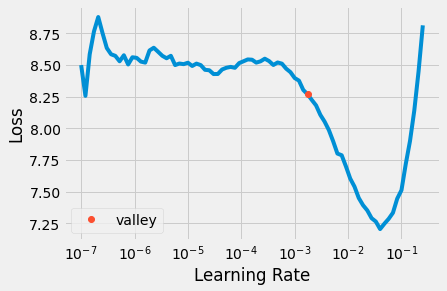

In [10]:
dls = get_dls(df)
print(f"Train Batches: {len(dls.train):>8}", f"Validation Batches: {len(dls.valid):>3}", sep = "\n")
device = "cuda" if torch.cuda.is_available() else "cpu"
loss = PolyLoss().to(device)
learn = vision_learner(dls, resnet50, metrics = [accuracy, F1Score(average="macro"), test_acc, test_f1], loss_func = loss)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,testAccuracy,testF1Score,time
0,7.209084,3.655359,0.498039,0.456425,0.440722,0.401084,00:48
1,4.382580,1.895744,0.718627,0.703633,0.703692,0.677577,00:46
2,2.695467,1.285863,0.803922,0.797119,0.785006,0.768215,00:46
3,1.611618,1.055037,0.847059,0.845694,0.820621,0.806932,00:46
4,1.130057,0.936282,0.859804,0.857615,0.843227,0.836347,00:46
5,0.793251,0.905355,0.862745,0.859028,0.857213,0.850194,00:46
6,0.524094,0.853853,0.880392,0.877968,0.866808,0.857243,00:46
7,0.442224,0.840035,0.872549,0.869896,0.867296,0.858622,00:46


Better model found at epoch 0 with valid_loss value: 3.6553592681884766.


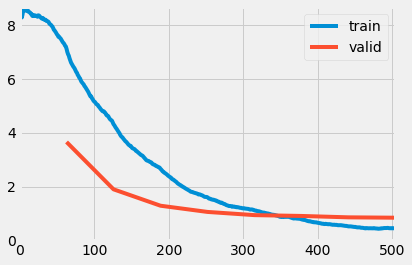

Better model found at epoch 1 with valid_loss value: 1.8957438468933105.
Better model found at epoch 2 with valid_loss value: 1.2858632802963257.
Better model found at epoch 3 with valid_loss value: 1.055037498474121.
Better model found at epoch 4 with valid_loss value: 0.9362823367118835.
Better model found at epoch 5 with valid_loss value: 0.9053552150726318.
Better model found at epoch 6 with valid_loss value: 0.8538525700569153.
Better model found at epoch 7 with valid_loss value: 0.8400352597236633.


In [11]:
learn.fit_one_cycle(8, lr_max = 1.7e-3, cbs = [WandbCallback(n_preds = 10),
                                               SaveModelCallback(fname = "../models/polyLoss_frozen_model"), 
                                               CSVLogger(fname = "../logs/polyLoss_frozen.csv"),
                                               ShowGraphCallback()])

SuggestedLRs(valley=2.511886486900039e-05)

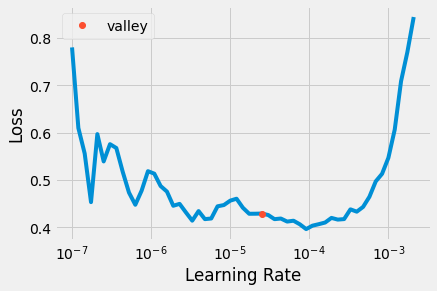

In [12]:
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,f1_score,testAccuracy,testF1Score,time
0,0.392040,0.827210,0.878431,0.876344,0.868271,0.860294,00:48
1,0.395745,0.807290,0.878431,0.876817,0.873801,0.864730,00:49
2,0.361759,0.787130,0.886275,0.884144,0.878192,0.869607,00:48
3,0.322256,0.746058,0.892157,0.891162,0.880306,0.873744,00:48
4,0.281159,0.726136,0.891176,0.889593,0.886160,0.877980,00:48
5,0.255891,0.698657,0.893137,0.891568,0.884046,0.874806,00:48
6,0.224263,0.661774,0.901961,0.900479,0.882745,0.875202,00:48
7,0.225150,0.652332,0.907843,0.906444,0.889250,0.878727,00:48
8,0.182797,0.641109,0.906863,0.905757,0.892340,0.883050,00:48
9,0.134657,0.641541,0.911765,0.910383,0.894942,0.885005,00:48


Better model found at epoch 0 with valid_loss value: 0.8272095918655396.


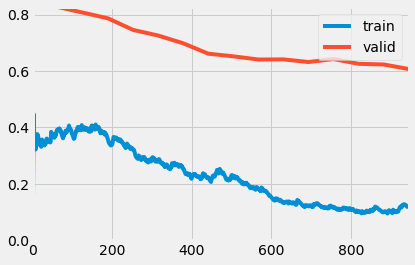

Better model found at epoch 1 with valid_loss value: 0.8072901368141174.
Better model found at epoch 2 with valid_loss value: 0.7871301770210266.
Better model found at epoch 3 with valid_loss value: 0.7460578083992004.
Better model found at epoch 4 with valid_loss value: 0.726136326789856.
Better model found at epoch 5 with valid_loss value: 0.6986572742462158.
Better model found at epoch 6 with valid_loss value: 0.6617744565010071.
Better model found at epoch 7 with valid_loss value: 0.6523322463035583.
Better model found at epoch 8 with valid_loss value: 0.6411092877388.
Better model found at epoch 10 with valid_loss value: 0.6321401596069336.
Better model found at epoch 12 with valid_loss value: 0.6258172988891602.
Better model found at epoch 13 with valid_loss value: 0.6235100626945496.
Better model found at epoch 14 with valid_loss value: 0.6074169874191284.


In [14]:
learn.fit_one_cycle(15, lr_max = slice(1e-5, 1e-4), cbs = [WandbCallback(n_preds = 10),
                                                           SaveModelCallback(fname = "../models/polyLoss_unfrozen_model"), 
                                                           CSVLogger(fname = "../logs/polyLoss_unfrozen_loss.csv"),
                                                           ShowGraphCallback()])

In [15]:
learn.export("../models/polyLoss_final_model.pkl")

In [16]:
# Log the frozen and unfrozen runs logs to wandb
frozen_logs = pd.read_csv("../logs/polyLoss_frozen.csv")
table = wandb.Table(dataframe = frozen_logs)
wandb.run.log({"FrozenPolyLossModelTrainingSummary": table})

unfrozen_logs = pd.read_csv("../logs/polyLoss_unfrozen_loss.csv")
table = wandb.Table(dataframe = unfrozen_logs)
wandb.run.log({"UnfrozenPolyLossModelTrainingSummary": table})